#### Libraries:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import time

#NLP
import nltk
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Prerana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Data Acquisition

In [2]:
df=pd.read_csv('Reviews.csv')
df.head()

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Unnamed: 0               23486 non-null  int64 
 1   Clothing ID              23486 non-null  int64 
 2   Age                      23486 non-null  int64 
 3   Title                    19676 non-null  object
 4   Review Text              22641 non-null  object
 5   Rating                   23486 non-null  int64 
 6   Recommended IND          23486 non-null  int64 
 7   Positive Feedback Count  23486 non-null  int64 
 8   Division Name            23472 non-null  object
 9   Department Name          23472 non-null  object
 10  Class Name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [4]:
df['Clothing ID'].nunique()

1206

In [5]:
df.describe()

,Unnamed: 0,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000,23486.000000
mean,11742.500000,918.118709,43.198544,4.196032,0.822362,2.535936
std,6779.968547,203.298980,12.279544,1.110031,0.382216,5.702202
min,0.000000,0.000000,18.000000,1.000000,0.000000,0.000000
25%,5871.250000,861.000000,34.000000,4.000000,1.000000,0.000000
50%,11742.500000,936.000000,41.000000,5.000000,1.000000,1.000000
75%,17613.750000,1078.000000,52.000000,5.000000,1.000000,3.000000
max,23485.000000,1205.000000,99.000000,5.000000,1.000000,122.000000


In [6]:
df.columns

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

In [7]:
df.columns=['_'.join(name.lower().strip().split()) for name in df.columns] #for easy access

In [8]:
df.columns

Index(['unnamed:_0', 'clothing_id', 'age', 'title', 'review_text', 'rating',
       'recommended_ind', 'positive_feedback_count', 'division_name',
       'department_name', 'class_name'],
      dtype='object')

In [9]:
df.drop(['unnamed:_0'],axis=1,inplace=True)

In [10]:
df['rating'].nunique()

5

In [11]:
def rating_converter(rating):
    if rating in {1,2}:
        return -1
    elif rating==3:
        return 0
    elif rating in {4,5}:
        return 1
    
df['sentiment']=df['rating'].apply(lambda rating :rating_converter(rating=rating))

In [12]:
df.drop('rating',axis=1,inplace=True)

### 2. EDA

In [13]:
df.isnull().sum()

clothing_id                   0
age                           0
title                      3810
review_text                 845
recommended_ind               0
positive_feedback_count       0
division_name                14
department_name              14
class_name                   14
sentiment                     0
dtype: int64

In [14]:
print('Missing data in title',df['title'].isna().mean().round(2))
print('Missing data in review_text',df['review_text'].isna().mean().round(2))

Missing data in title 0.16
Missing data in review_text 0.04


In [15]:
target='sentiment'
features=df.columns.drop('sentiment')

print('Model target:',target)
print('Model features:',features)

Model target: sentiment
Model features: Index(['clothing_id', 'age', 'title', 'review_text', 'recommended_ind',
       'positive_feedback_count', 'division_name', 'department_name',
       'class_name'],
      dtype='object')


In [16]:
#check if feature is numerical or categorical

numerical_feature=df[features].select_dtypes(include=np.number).columns
print('Numerical features:',numerical_feature)

categorical_feature=df[features].select_dtypes(include='object').columns
print('Categorical features:',categorical_feature)

Numerical features: Index(['clothing_id', 'age', 'recommended_ind', 'positive_feedback_count'], dtype='object')
Categorical features: Index(['title', 'review_text', 'division_name', 'department_name',
       'class_name'],
      dtype='object')


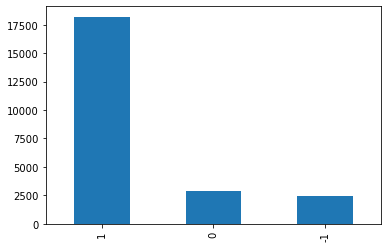

value counts:
  1    0.775270
 0    0.122243
-1    0.102487
Name: sentiment, dtype: float64


In [17]:
df[target].value_counts().plot.bar()
plt.show()
print('value counts:\n',df[target].value_counts(normalize=True))

##### Univariate analysis

In [18]:
#Categorical variable

df['title'].value_counts()

Love it!                                   136
Beautiful                                   95
Love                                        88
Love!                                       84
Beautiful!                                  72
                                          ... 
Perfect transition dress                     1
The perfect spring dress!                    1
Super soft but can make you look frumpy      1
More structured than a cardi                 1
Please make more like this one!              1
Name: title, Length: 13993, dtype: int64

In [19]:
df['title'].unique()

array([nan, 'Some major design flaws', 'My favorite buy!', ...,
       'Cute, but see through',
       'Very cute dress, perfect for summer parties and we',
       'Please make more like this one!'], dtype=object)

In [20]:
df['review_text'].value_counts()

Perfect fit and i've gotten so many compliments. i buy all my suits from here now!                                                                                                                                                                                                                                                                                                                                                                                                                                        3
I purchased this and another eva franco dress during retailer's recent 20% off sale. i was looking for dresses that were work appropriate, but that would also transition well to happy hour or date night. they both seemed to be just what i was looking for. i ordered a 4 regular and a 6 regular, as i am usually in between sizes. the 4 was definitely too small. the 6 fit, technically, but was very ill fitting. not only is the dress itself short, but it is very short-waisted. i am only 5'3",

In [21]:
df['division_name'].value_counts()

General           13850
General Petite     8120
Initmates          1502
Name: division_name, dtype: int64

In [22]:
df['department_name'].value_counts()

Tops        10468
Dresses      6319
Bottoms      3799
Intimate     1735
Jackets      1032
Trend         119
Name: department_name, dtype: int64

In [23]:
df['class_name'].value_counts()

Dresses           6319
Knits             4843
Blouses           3097
Sweaters          1428
Pants             1388
Jeans             1147
Fine gauge        1100
Skirts             945
Jackets            704
Lounge             691
Swim               350
Outerwear          328
Shorts             317
Sleep              228
Legwear            165
Intimates          154
Layering           146
Trend              119
Casual bottoms       2
Chemises             1
Name: class_name, dtype: int64

division_name


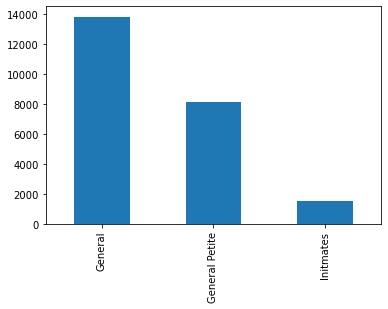

department_name


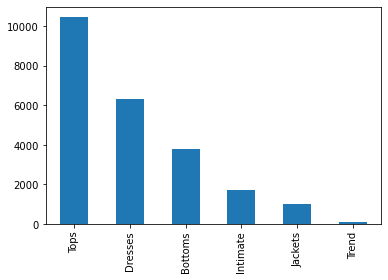

class_name


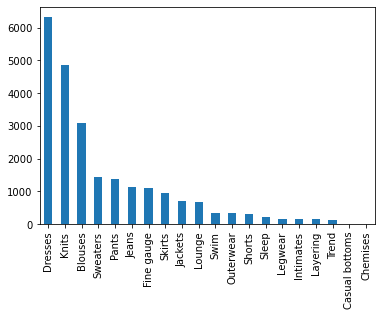

In [24]:
for i in categorical_feature:
    if len(df[i].value_counts())<50:
        print(i)
        df[i].value_counts().plot.bar()
        plt.show()

In [25]:
#numerical_variables
numerical_feature

Index(['clothing_id', 'age', 'recommended_ind', 'positive_feedback_count'], dtype='object')

In [26]:
for i in numerical_feature:
    print(i)
    print(df[i].value_counts())
    print('*'*100)

clothing_id
1078    1024
862      806
1094     756
1081     582
872      545
        ... 
776        1
668        1
633        1
734        1
522        1
Name: clothing_id, Length: 1206, dtype: int64
****************************************************************************************************
age
39    1269
35     909
36     842
34     804
38     780
      ... 
93       2
90       2
86       2
99       2
92       1
Name: age, Length: 77, dtype: int64
****************************************************************************************************
recommended_ind
1    19314
0     4172
Name: recommended_ind, dtype: int64
****************************************************************************************************
positive_feedback_count
0      11176
1       4043
2       2193
3       1433
4        922
       ...  
94         1
117        1
71         1
84         1
59         1
Name: positive_feedback_count, Length: 82, dtype: int64
**************************************

clothing_id


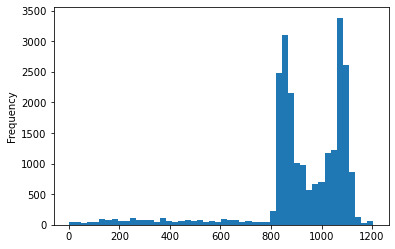

age


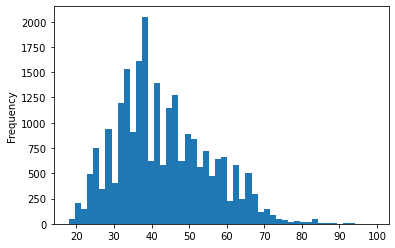

recommended_ind


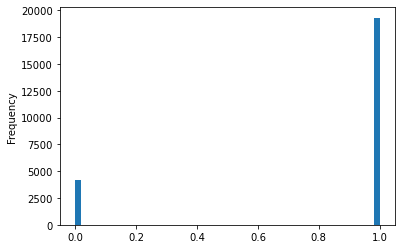

positive_feedback_count


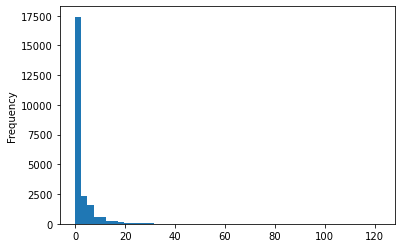

In [27]:
for i in numerical_feature:
    print(i)
    df[i].plot.hist(bins=50)
    plt.show()

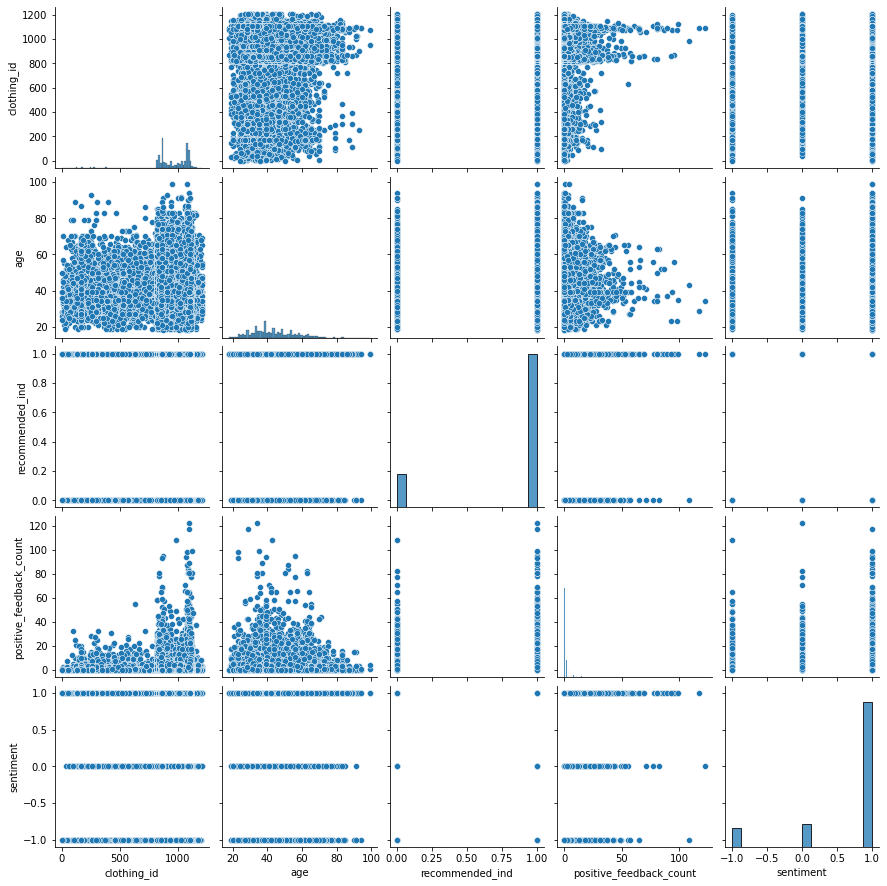

In [28]:
sns.pairplot(df)
plt.show()

<AxesSubplot:>

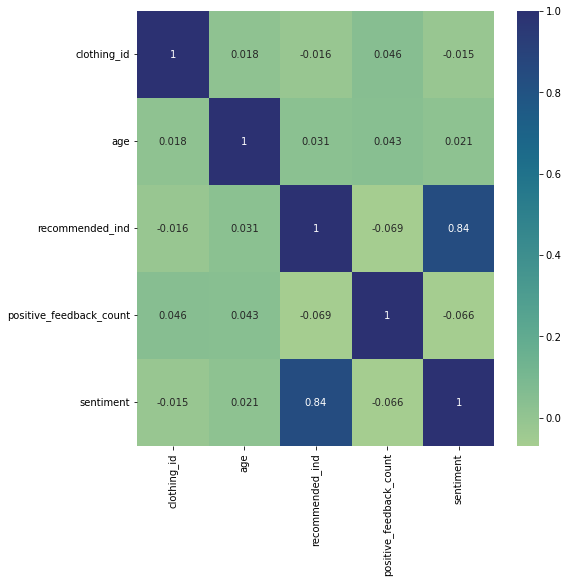

In [29]:
corr=df.corr()
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corr,annot=True,cmap="crest")

### 3.Feature Selection

In [30]:
#select features
final_df=df[['review_text','sentiment']]
final_df.dropna(inplace=True)

C:\Users\Prerana\AppData\Local\Temp\ipykernel_25684\2505352459.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.dropna(inplace=True)


In [31]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22641 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_text  22641 non-null  object
 1   sentiment    22641 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 530.6+ KB


In [32]:
final_df.head()

,review_text,sentiment
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1


In [33]:
final_df['review_text'][1]

'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

In [34]:
final_df[final_df.duplicated()]

,review_text,sentiment
10067,Perfect fit and i've gotten so many compliment...,1
11074,"Lightweight, soft cotton top and shorts. i thi...",1
12526,I purchased this and another eva franco dress ...,-1
13354,Perfect fit and i've gotten so many compliment...,1
14275,I bought this shirt at the store and after goi...,1
21470,The sweater and skirt are so pretty! they're r...,1
21888,"Love, love these jeans. being short they come ...",1


In [35]:
final_df.drop_duplicates(inplace=True)

C:\Users\Prerana\AppData\Local\Temp\ipykernel_25684\2893831713.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.drop_duplicates(inplace=True)


In [36]:
final_df.shape

(22634, 2)

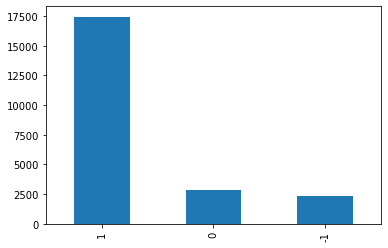

 1    17442
 0     2823
-1     2369
Name: sentiment, dtype: int64


In [37]:
# Target distribution

final_df.sentiment.value_counts().plot.bar()
plt.show()
print(final_df.sentiment.value_counts())

In [38]:
final_df['review_length']=final_df['review_text'].apply(len)
final_df.head()

C:\Users\Prerana\AppData\Local\Temp\ipykernel_25684\3706417113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['review_length']=final_df['review_text'].apply(len)


,review_text,sentiment,review_length
0,Absolutely wonderful - silky and sexy and comf...,1,53
1,Love this dress! it's sooo pretty. i happene...,1,303
2,I had such high hopes for this dress and reall...,0,500
3,"I love, love, love this jumpsuit. it's fun, fl...",1,124
4,This shirt is very flattering to all due to th...,1,192


In [39]:
final_df.describe()

,sentiment,review_length
count,22634.000000,22634.000000
mean,0.665945,308.698065
std,0.657124,143.932380
min,-1.000000,9.000000
25%,1.000000,186.000000
50%,1.000000,301.000000
75%,1.000000,458.750000
max,1.000000,508.000000


In [40]:
for i in final_df.sentiment.unique():
    print(final_df.sentiment.unique()[i])
    print(final_df[final_df.sentiment==i].review_length.value_counts(bins=30))

0
(491.367, 508.0]      3680
(208.6, 225.233]       705
(158.7, 175.333]       649
(191.967, 208.6]       648
(175.333, 191.967]     638
(258.5, 275.133]       637
(125.433, 142.067]     631
(241.867, 258.5]       626
(225.233, 241.867]     596
(291.767, 308.4]       592
(142.067, 158.7]       588
(108.8, 125.433]       577
(275.133, 291.767]     556
(308.4, 325.033]       547
(341.667, 358.3]       516
(75.533, 92.167]       498
(92.167, 108.8]        494
(325.033, 341.667]     475
(358.3, 374.933]       470
(391.567, 408.2]       434
(374.933, 391.567]     430
(58.9, 75.533]         405
(424.833, 441.467]     388
(441.467, 458.1]       381
(408.2, 424.833]       353
(458.1, 474.733]       305
(474.733, 491.367]     302
(42.267, 58.9]         232
(25.633, 42.267]        63
(8.5, 25.633]           26
Name: review_length, dtype: int64
1
(487.9, 504.0]    688
(326.9, 343.0]    120
(262.5, 278.6]    118
(198.1, 214.2]    112
(165.9, 182.0]     98
(343.0, 359.1]     98
(278.6, 294.7]     9

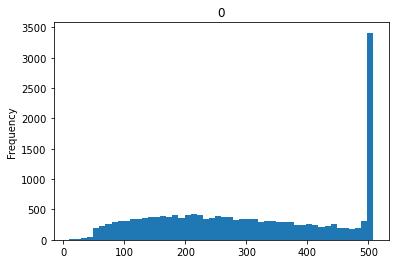

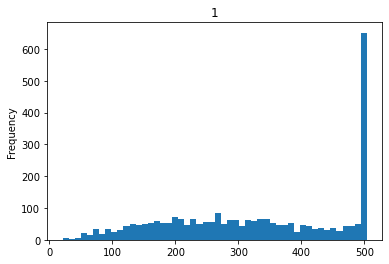

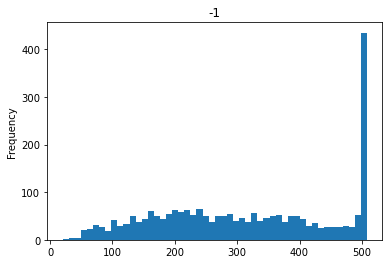

In [41]:
for i in final_df.sentiment.unique():
    final_df[final_df.sentiment==i].review_length.plot.hist(bins=50)
    plt.title(final_df.sentiment.unique()[i])
    plt.show()

### 4. Text Preprocessing

In [42]:
## Text Polarity
final_df['polarity'] = final_df['review_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
final_df.head(5)

C:\Users\Prerana\AppData\Local\Temp\ipykernel_25684\1723556540.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['polarity'] = final_df['review_text'].apply(lambda x: TextBlob(x).sentiment.polarity)


,review_text,sentiment,review_length,polarity
0,Absolutely wonderful - silky and sexy and comf...,1,53,0.633333
1,Love this dress! it's sooo pretty. i happene...,1,303,0.339583
2,I had such high hopes for this dress and reall...,0,500,0.073675
3,"I love, love, love this jumpsuit. it's fun, fl...",1,124,0.550000
4,This shirt is very flattering to all due to th...,1,192,0.512891


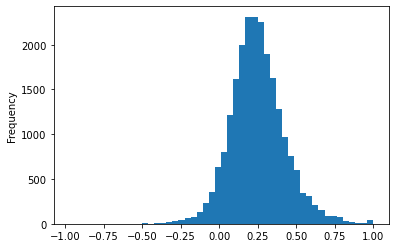

In [43]:
final_df.polarity.plot.hist(bins=50)
plt.show()


<AxesSubplot:>

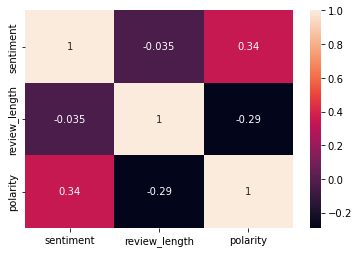

In [44]:
sns.heatmap(final_df.corr(),annot=True)

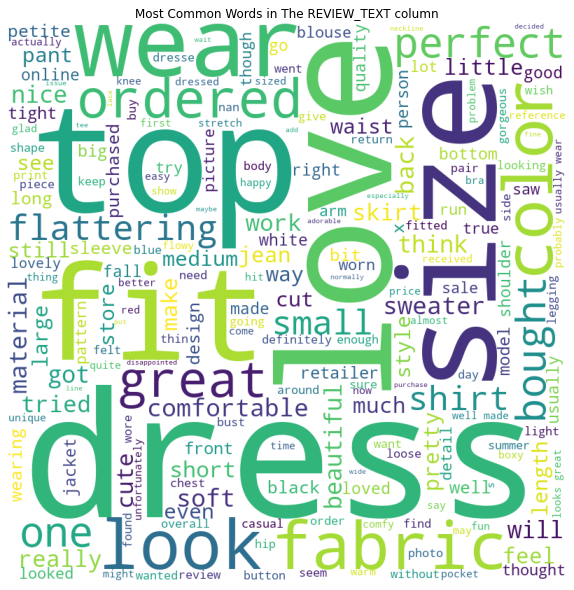

In [50]:
def CloudWord(column):
    comment_words = ''
    stopwords = set(STOPWORDS)
    
    for i in df[column]:
        i=str(i)
        tokens=i.split()
        
        for j in range(len(tokens)):
            tokens[j]=tokens[j].lower()
        comment_words += " ".join(tokens)+" "
    
    wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)
    
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.title(f"Most Common Words in The {column.upper()} column")
    plt.axis("off")
    plt.tight_layout(pad = 0)
  
    plt.show()
    
CloudWord('review_text')

In [52]:
#stemming

snow_stemmer = SnowballStemmer(language='english')
def preprocess_text(data):
    review = re.sub('[^a-zA-Z]', ' ', data)
    review = review.lower()
    review = review.split()
    
    review = [snow_stemmer.stem(word) for word in review if not word in stopwords.words('english')] # Remove the stopwords
    review = ' '.join(review)
    return review

In [53]:
X = final_df["review_text"]
y = final_df["sentiment"]

X = X.apply(preprocess_text)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state = 42 )

print('Datasets shapes: ', X_train.shape, X_test.shape)

Datasets shapes:  (15843,) (6791,)


In [64]:
#creating bag of words
MAX_FEATURES = 3000
cv = CountVectorizer(max_features=MAX_FEATURES)
X_trainds = cv.fit_transform(X_train).toarray()
X_testds = cv.transform(X_test).toarray()

### 5. Model Building

In [54]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, roc_auc_score,balanced_accuracy_score, classification_report, confusion_matrix

Accuracy Score 0.7760270946841408
------------------------------------------------------------
Balanced Accuracy Score 0.3333333333333333


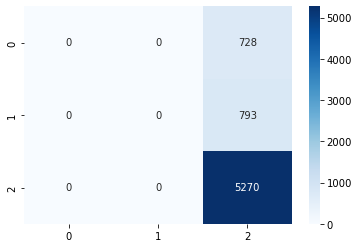

In [65]:
#dummy classifier

from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_trainds, y_train)

print("Accuracy Score",accuracy_score(y_test, dummy_clf.predict(X_testds)))
print("-"*60)
print("Balanced Accuracy Score",balanced_accuracy_score(y_test, dummy_clf.predict(X_testds)))

cm = confusion_matrix(y_test,dummy_clf.predict(X_testds))
sns.heatmap(cm,cmap='Blues',annot=True,fmt='d')
plt.show()

In [66]:
random_state = 42
classifiers = [DecisionTreeClassifier(random_state = random_state,class_weight = "balanced"),
             RandomForestClassifier(random_state = random_state),
             KNeighborsClassifier(),
             MultinomialNB()]

trained_classifier = []
acc_score_results = []
f1_score_results = []
roc_auc_score_results = []
elapsed_time = []

for model in classifiers:
    st = time.time()
    classifier = model.fit(X_trainds,y_train)
    y_pred = classifier.predict(X_testds)
    et = time.time()

    trained_classifier.append(classifier)
    acc_score_results.append(balanced_accuracy_score(y_test,y_pred))
    f1_score_results.append(f1_score(y_test,y_pred,average = 'weighted'))
    roc_auc_score_results.append(roc_auc_score(y_test,classifier.predict_proba(X_testds),multi_class='ovr')) # One-vs-rest
    elapsed_time.append(float(et-st))

In [67]:
results_df = pd.DataFrame(data = {"trained_classifier":trained_classifier,
                                  "acc_score_results":acc_score_results,
                                  "f1_score_results":f1_score_results,
                                  "roc_auc_score_results":roc_auc_score_results,
                                  "elapsed_time":elapsed_time})

In [68]:
results_df

,trained_classifier,acc_score_results,f1_score_results,roc_auc_score_results,elapsed_time
0,DecisionTreeClassifier(class_weight='balanced'...,0.474272,0.706182,0.626610,16.407509
1,"(DecisionTreeClassifier(max_features='sqrt', r...",0.403138,0.727470,0.856098,75.659626
2,KNeighborsClassifier(),0.386637,0.714287,0.647729,12.190655
3,MultinomialNB(),0.612761,0.808482,0.880436,2.148741


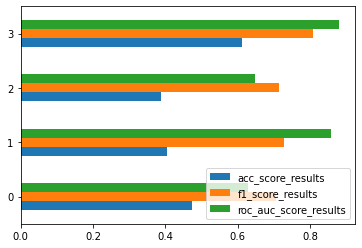

In [69]:
results_df[["acc_score_results","f1_score_results","roc_auc_score_results"]].plot.barh()
plt.show()

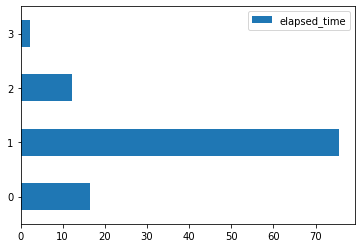

In [70]:
results_df.plot.barh(y = "elapsed_time")
plt.show()

In [71]:
#bag of words classification report

for i in range(len(results_df)):
    y_pred = results_df.trained_classifier[i].predict(X_testds)
    print("\n",str(results_df.trained_classifier[i]))
    print(classification_report(y_test,y_pred))
    print("-"*90,"\n")


 DecisionTreeClassifier(class_weight='balanced', random_state=42)
              precision    recall  f1-score   support

          -1       0.29      0.34      0.31       728
           0       0.21      0.29      0.24       793
           1       0.87      0.80      0.83      5270

    accuracy                           0.69      6791
   macro avg       0.45      0.47      0.46      6791
weighted avg       0.73      0.69      0.71      6791

------------------------------------------------------------------------------------------ 


 RandomForestClassifier(random_state=42)
              precision    recall  f1-score   support

          -1       0.64      0.18      0.28       728
           0       0.49      0.04      0.07       793
           1       0.80      0.99      0.89      5270

    accuracy                           0.80      6791
   macro avg       0.65      0.40      0.41      6791
weighted avg       0.75      0.80      0.73      6791

------------------------------------

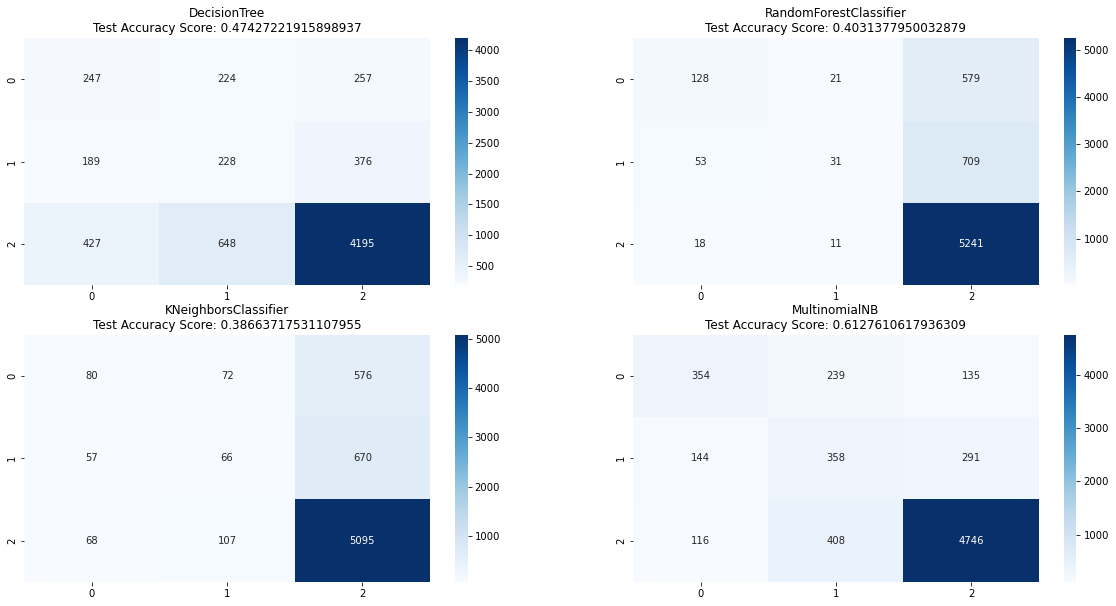

In [72]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(20,10))


cm_DecisionTree = confusion_matrix(y_test,results_df.trained_classifier[0].predict(X_testds))
cm_RandomForestClassifier = confusion_matrix(y_test,results_df.trained_classifier[1].predict(X_testds))
cm_KNeighborsClassifier = confusion_matrix(y_test,results_df.trained_classifier[2].predict(X_testds))
cm_MultinomialNB = confusion_matrix(y_test,results_df.trained_classifier[3].predict(X_testds))

sns.heatmap(cm_DecisionTree,cmap='Blues',annot=True,fmt='d',ax = ax1)
ax1.set_title("DecisionTree\nTest Accuracy Score: "+str(results_df.acc_score_results[0])  )

sns.heatmap(cm_RandomForestClassifier,cmap='Blues',annot=True,fmt='d',ax = ax2)
ax2.set_title("RandomForestClassifier\nTest Accuracy Score: "+str(results_df.acc_score_results[1]) )

sns.heatmap(cm_KNeighborsClassifier,cmap='Blues',annot=True,fmt='d',ax = ax3)
ax3.set_title("KNeighborsClassifier\nTest Accuracy Score: "+str(results_df.acc_score_results[2]) )

sns.heatmap(cm_MultinomialNB,cmap='Blues',annot=True,fmt='d',ax = ax4)
ax4.set_title("MultinomialNB\nTest Accuracy Score: "+str(results_df.acc_score_results[3]))

plt.show()

In [73]:
#TF-IDF vectorizer

vectorizer = TfidfVectorizer()
X_trainds_tfidf = vectorizer.fit_transform(X_train).toarray()
X_testds_tfidf = vectorizer.transform(X_test).toarray()

In [74]:
X_trainds_tfidf.shape

(15843, 7860)

In [75]:
random_state = 42
classifiers = {  DecisionTreeClassifier(random_state = random_state,class_weight = "balanced"),
                 RandomForestClassifier(random_state = random_state),
                 KNeighborsClassifier(),
                 MultinomialNB()}

tf_idf_trained_classifier = []
tf_idf_acc_score_results = []
tf_idf_f1_score_results = []
tf_idf_roc_auc_score_results = []
tf_idf_elapsed_time = []

for model in classifiers:
    st = time.time()
    classifier = model.fit(X_trainds_tfidf,y_train)
    y_pred = classifier.predict(X_testds_tfidf)
    et = time.time()
    
    tf_idf_trained_classifier.append(classifier)
    tf_idf_acc_score_results.append(balanced_accuracy_score(y_test,y_pred))
    tf_idf_f1_score_results.append(f1_score(y_test,y_pred,average = 'weighted'))
    tf_idf_roc_auc_score_results.append(roc_auc_score(y_test,classifier.predict_proba(X_testds_tfidf),multi_class='ovr')) #One-vs-rest
    tf_idf_elapsed_time.append(float(et-st))

In [76]:
tf_idf_results_df = pd.DataFrame(data = {"tf_idf_trained_classifier":tf_idf_trained_classifier,
                                          "tf_idf_acc_score_results":tf_idf_acc_score_results,
                                          "tf_idf_f1_score_results":tf_idf_f1_score_results,
                                          "tf_idf_roc_auc_score_results":tf_idf_roc_auc_score_results,
                                          "tf_idf_elapsed_time":tf_idf_elapsed_time
                                            })

In [77]:
tf_idf_results_df

,tf_idf_trained_classifier,tf_idf_acc_score_results,tf_idf_f1_score_results,tf_idf_roc_auc_score_results,tf_idf_elapsed_time
0,DecisionTreeClassifier(class_weight='balanced'...,0.478172,0.702651,0.624213,34.909037
1,KNeighborsClassifier(),0.448843,0.747733,0.725334,26.186146
2,"(DecisionTreeClassifier(max_features='sqrt', r...",0.372612,0.707626,0.864689,134.364243
3,MultinomialNB(),0.337454,0.681506,0.855122,0.598868


<AxesSubplot:>

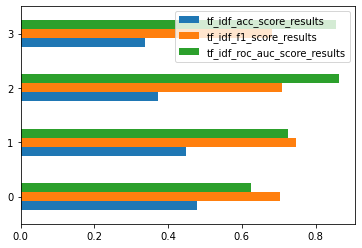

In [78]:
tf_idf_results_df[["tf_idf_acc_score_results","tf_idf_f1_score_results","tf_idf_roc_auc_score_results"]].plot.barh()

<AxesSubplot:>

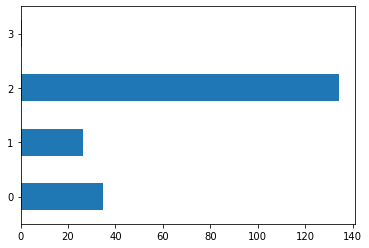

In [79]:
tf_idf_results_df.tf_idf_elapsed_time.plot.barh()

In [80]:
### TF-IDF Classification Reports

for i in range(len(tf_idf_results_df)):
    y_pred = tf_idf_results_df.tf_idf_trained_classifier[i].predict(X_testds_tfidf)
    print("\n",str(tf_idf_results_df.tf_idf_trained_classifier[i]))
    print(classification_report(y_test,y_pred))
    print("-"*90,"\n")


 DecisionTreeClassifier(class_weight='balanced', random_state=42)
              precision    recall  f1-score   support

          -1       0.30      0.36      0.33       728
           0       0.21      0.28      0.24       793
           1       0.86      0.79      0.82      5270

    accuracy                           0.69      6791
   macro avg       0.46      0.48      0.46      6791
weighted avg       0.72      0.69      0.70      6791

------------------------------------------------------------------------------------------ 


 KNeighborsClassifier()
              precision    recall  f1-score   support

          -1       0.44      0.25      0.32       728
           0       0.30      0.15      0.20       793
           1       0.84      0.95      0.89      5270

    accuracy                           0.78      6791
   macro avg       0.52      0.45      0.47      6791
weighted avg       0.73      0.78      0.75      6791

-----------------------------------------------------

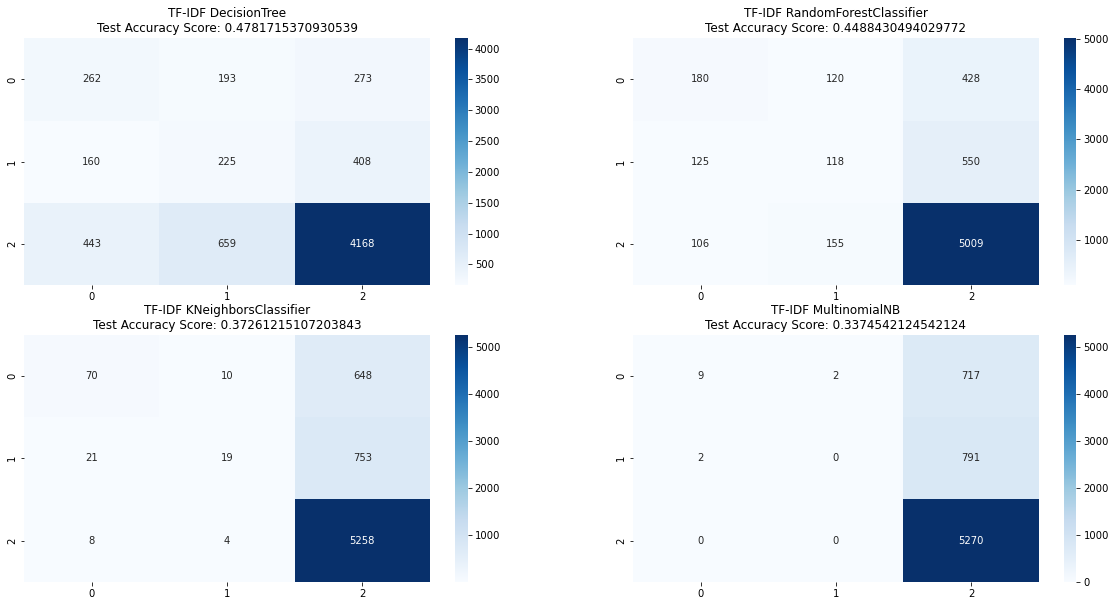

In [81]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(20,10))


cm_DecisionTree = confusion_matrix(y_test,tf_idf_results_df.tf_idf_trained_classifier[0].predict(X_testds_tfidf))
cm_RandomForestClassifier = confusion_matrix(y_test,tf_idf_results_df.tf_idf_trained_classifier[1].predict(X_testds_tfidf))
cm_KNeighborsClassifier = confusion_matrix(y_test,tf_idf_results_df.tf_idf_trained_classifier[2].predict(X_testds_tfidf))
cm_MultinomialNB = confusion_matrix(y_test,tf_idf_results_df.tf_idf_trained_classifier[3].predict(X_testds_tfidf))

sns.heatmap(cm_DecisionTree,cmap='Blues',annot=True,fmt='d',ax = ax1)
ax1.set_title("TF-IDF DecisionTree\nTest Accuracy Score: "+str(tf_idf_results_df.tf_idf_acc_score_results[0])  )

sns.heatmap(cm_RandomForestClassifier,cmap='Blues',annot=True,fmt='d',ax = ax2)
ax2.set_title("TF-IDF RandomForestClassifier\nTest Accuracy Score: "+str(tf_idf_results_df.tf_idf_acc_score_results[1]) )

sns.heatmap(cm_KNeighborsClassifier,cmap='Blues',annot=True,fmt='d',ax = ax3)
ax3.set_title("TF-IDF KNeighborsClassifier\nTest Accuracy Score: "+str(tf_idf_results_df.tf_idf_acc_score_results[2]) )

sns.heatmap(cm_MultinomialNB,cmap='Blues',annot=True,fmt='d',ax = ax4)
ax4.set_title("TF-IDF MultinomialNB\nTest Accuracy Score: "+str(tf_idf_results_df.tf_idf_acc_score_results[3]))

plt.show()

In [ ]:
#BoW gives us a better result for this dataset
#Naive Bayes gives the best results for our analysis